In [2]:
#|defualt_exp app

Ref

- https://www.kaggle.com/code/hengzheng/dog-breeds-classifier
- https://huggingface.co/google/vit-base-patch16-224
- https://www.tanishq.ai/blog/gradio_hf_spaces_tutorial

In [ ]:
!pip install -q transformers

# Dataset

- kaggle dataset에서 다운방법 찾기

In [1]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

--2023-03-28 11:25:09--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  38.4MB/s    in 22s     

2023-03-28 11:25:31 (34.9 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2023-03-28 11:25:32--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  8.90MB/s    in 2.3s    

2023-03-28 11:25:34 (8.90 MB/s) - ‘annotat

In [2]:
ls

__notebook_source__.ipynb  annotation.tar  images.tar


In [3]:
import tarfile

with tarfile.open('images.tar', 'r') as tar:
    tar.extractall()
    
with tarfile.open('annotation.tar', 'r') as tar:
    tar.extractall()

In [5]:
import os

breed_list = os.listdir("Images/")

num_total_images, num_classes = 0, len(breed_list)

for breed in breed_list:
    num_total_images += len(os.listdir(f"Images/{breed}"))
    
print(f'{num_classes} breeds \
      {num_total_images} images')
    

120 breeds       20580 images


## Show Some Pictures

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #

def show_dir_images(breed, n_to_show):
    img_dir = f"Images/{breed}/"
    if n_to_show > len(os.listdir(img_dir)):
        return
    
    plt.figure(figsize=(16,16))
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show//4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02090379-redbone


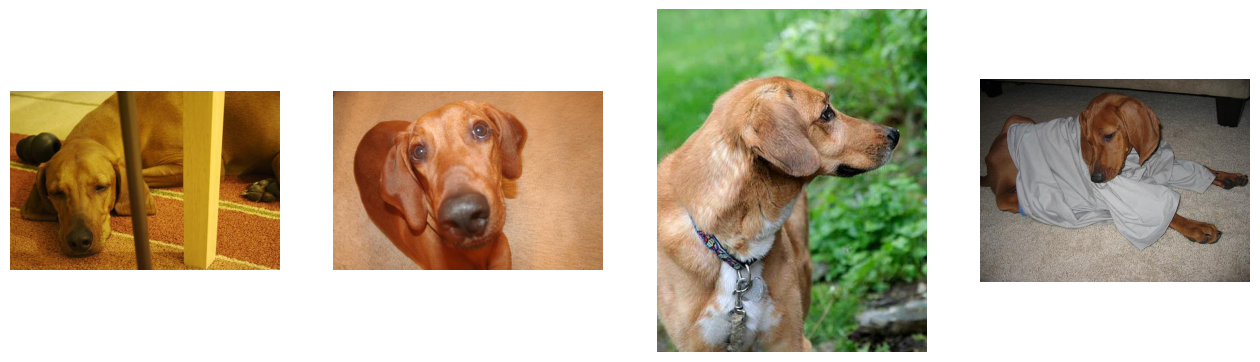

In [7]:
print(breed_list[1])
show_dir_images(breed_list[1], 4)

## Crop and Save Pictures

In [8]:
import xml.etree.ElementTree as ET
from PIL import Image

In [9]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise


os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('Annotation/{}'.format(breed)):
        img = Image.open('Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

Created 120 folders to store cropped images of the different breeds.
CPU times: user 2min 22s, sys: 2.65 s, total: 2min 25s
Wall time: 2min 25s


#### (참고) 나중에 빠른학습을 위해 data.tar만들기

In [24]:
import tarfile

# 압축할 디렉토리 경로와 파일명 설정
dir_path = './data'
tar_filename = './data.tar'

# tar 아카이브 파일 생성하기
with tarfile.open(tar_filename, mode='w') as tar:
    tar.add(dir_path, arcname='data')

In [ ]:
import tarfile

# 압축 해제할 파일 경로와 파일명 설정
tar_filename = './data.tar'
extract_path = './'

# tar 아카이브 파일 해제하기
with tarfile.open(tar_filename, mode='r') as tar:
    tar.extractall(path=extract_path)

## Prepare (X, y)

In [11]:
label_maps = {}
label_maps_rev = {}

for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [12]:
label_maps_list = [label_maps, label_maps_rev]

import pickle
with open('label_maps.pkl', 'wb') as f:
    pickle.dump(label_maps_list, f)

In [13]:
from keras.utils import np_utils

def paths_and_labels():
    paths = list()    # ['data/breed/', ]
    labels = list()   # ['breed', ]
    targets = list()  # ['label_maps[breed]->int', ] -> one-hot encoding
    
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

In [14]:
targets

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Create Dataset

In [18]:
from transformers import ViTImageProcessor
from torch.utils.data import Dataset, DataLoader
from PIL import Image

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

class ImageDataset(Dataset):
    def __init__(self, paths, targets, shape):
        self.paths = paths
        self.targets = targets
        self.shape = shape

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        image = Image.open(self.paths[index])
        image = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        label = self.targets[index]
        return image, label
    

def create_data_loader(dataset, batch_size, shuffle=True):
    return DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

## Split Dataset

In [19]:
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.2, 
                                                  random_state=1111)

In [20]:
train_dataset = ImageDataset(train_paths, train_targets, shape=(224, 224))
train_loader = create_data_loader(train_dataset, batch_size=64)

valid_dataset = ImageDataset(val_paths, val_targets, shape=(224, 224))
valid_loader = create_data_loader(valid_dataset, batch_size=64)

# Model

In [21]:
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.nn.functional as F

pretrained_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

vit_model_output_size = 1000
new_model_output_size = 120

for param in pretrained_model.parameters():
    param.requires_grad = False

class ViTForDogBreedClassification(nn.Module):
    def __init__(self, num_classes=new_model_output_size):
        super(ViTForDogBreedClassification, self).__init__()
        self.vit_model = pretrained_model
        self.fc1 = nn.Linear(vit_model_output_size, num_classes)
        
    def forward(self, x):
        x = self.vit_model(x)['logits']
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

## Learning

In [22]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForDogBreedClassification()
model.to(device)

lr = 1e-4
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [23]:
from tqdm import tqdm

best_acc = 0.0  # 최고 정확도 초기화
patience = 3  # 조기 종료 기준 epoch 수
counter = 0  # epoch 수 세는 카운터 초기화

for epoch in range(num_epochs):
    # train
    model.train()
    train_loss = 0.0
    for batch_idx, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (batch_idx + 1) % 50 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {batch_idx+1}/{len(train_loader)}] [Train Loss: {train_loss/(batch_idx+1):.4f}]")

    # validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, total=len(valid_loader)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.argmax(dim=1).data)

        val_loss /= len(valid_loader)
        val_acc = val_correct.double() / len(valid_loader.dataset)

        print(f"[Epoch {epoch+1}/{num_epochs}] [Val Loss: {val_loss:.4f}] [Val Acc: {val_acc:.4f}]")

        # 최고 정확도일 때만 모델 저장
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'dog_breed_classification.pth')
            print("Model saved.")
        else:
            counter += 1
            if counter >= patience:
                print(f"No improvement after {patience} epochs. Training stopped.")
                break


 19%|█▉        | 50/258 [00:23<01:15,  2.75it/s]

[Epoch 1/20] [Batch 50/258] [Train Loss: 4.7785]


 39%|███▉      | 100/258 [00:41<00:57,  2.76it/s]

[Epoch 1/20] [Batch 100/258] [Train Loss: 4.7434]


 58%|█████▊    | 150/258 [01:00<00:39,  2.72it/s]

[Epoch 1/20] [Batch 150/258] [Train Loss: 4.6779]


 78%|███████▊  | 200/258 [01:18<00:20,  2.78it/s]

[Epoch 1/20] [Batch 200/258] [Train Loss: 4.5971]


 97%|█████████▋| 250/258 [01:36<00:02,  2.78it/s]

[Epoch 1/20] [Batch 250/258] [Train Loss: 4.5259]


100%|██████████| 65/65 [00:24<00:00,  2.67it/s]


[Epoch 1/20] [Val Loss: 4.1893] [Val Acc: 0.7274]
Model saved.


 19%|█▉        | 50/258 [00:18<01:16,  2.73it/s]

[Epoch 2/20] [Batch 50/258] [Train Loss: 4.1362]


 39%|███▉      | 100/258 [00:37<00:57,  2.74it/s]

[Epoch 2/20] [Batch 100/258] [Train Loss: 4.1237]


 58%|█████▊    | 150/258 [00:55<00:39,  2.71it/s]

[Epoch 2/20] [Batch 150/258] [Train Loss: 4.1144]


 78%|███████▊  | 200/258 [01:13<00:21,  2.75it/s]

[Epoch 2/20] [Batch 200/258] [Train Loss: 4.1045]


 97%|█████████▋| 250/258 [01:32<00:02,  2.76it/s]

[Epoch 2/20] [Batch 250/258] [Train Loss: 4.0975]


100%|██████████| 65/65 [00:24<00:00,  2.69it/s]


[Epoch 2/20] [Val Loss: 4.0608] [Val Acc: 0.7874]
Model saved.


 19%|█▉        | 50/258 [00:18<01:15,  2.75it/s]

[Epoch 3/20] [Batch 50/258] [Train Loss: 4.0596]


 39%|███▉      | 100/258 [00:37<00:57,  2.74it/s]

[Epoch 3/20] [Batch 100/258] [Train Loss: 4.0519]


 58%|█████▊    | 150/258 [00:55<00:39,  2.74it/s]

[Epoch 3/20] [Batch 150/258] [Train Loss: 4.0450]


 78%|███████▊  | 200/258 [01:13<00:21,  2.76it/s]

[Epoch 3/20] [Batch 200/258] [Train Loss: 4.0436]


 97%|█████████▋| 250/258 [01:31<00:02,  2.75it/s]

[Epoch 3/20] [Batch 250/258] [Train Loss: 4.0409]


100%|██████████| 65/65 [00:24<00:00,  2.69it/s]


[Epoch 3/20] [Val Loss: 4.0260] [Val Acc: 0.8144]
Model saved.


 19%|█▉        | 50/258 [00:18<01:15,  2.76it/s]

[Epoch 4/20] [Batch 50/258] [Train Loss: 4.0250]


 39%|███▉      | 100/258 [00:37<00:58,  2.71it/s]

[Epoch 4/20] [Batch 100/258] [Train Loss: 4.0135]


 58%|█████▊    | 150/258 [00:55<00:39,  2.76it/s]

[Epoch 4/20] [Batch 150/258] [Train Loss: 4.0111]


 78%|███████▊  | 200/258 [01:13<00:21,  2.70it/s]

[Epoch 4/20] [Batch 200/258] [Train Loss: 4.0107]


 97%|█████████▋| 250/258 [01:31<00:02,  2.75it/s]

[Epoch 4/20] [Batch 250/258] [Train Loss: 4.0095]


100%|██████████| 65/65 [00:24<00:00,  2.68it/s]


[Epoch 4/20] [Val Loss: 4.0079] [Val Acc: 0.8241]
Model saved.


 19%|█▉        | 50/258 [00:18<01:15,  2.74it/s]

[Epoch 5/20] [Batch 50/258] [Train Loss: 4.0017]


 39%|███▉      | 100/258 [00:37<00:57,  2.74it/s]

[Epoch 5/20] [Batch 100/258] [Train Loss: 3.9957]


 58%|█████▊    | 150/258 [00:55<00:38,  2.77it/s]

[Epoch 5/20] [Batch 150/258] [Train Loss: 3.9942]


 78%|███████▊  | 200/258 [01:13<00:21,  2.76it/s]

[Epoch 5/20] [Batch 200/258] [Train Loss: 3.9947]


 97%|█████████▋| 250/258 [01:31<00:02,  2.74it/s]

[Epoch 5/20] [Batch 250/258] [Train Loss: 3.9951]


100%|██████████| 65/65 [00:24<00:00,  2.68it/s]


[Epoch 5/20] [Val Loss: 3.9999] [Val Acc: 0.8265]
Model saved.


 19%|█▉        | 50/258 [00:18<01:15,  2.74it/s]

[Epoch 6/20] [Batch 50/258] [Train Loss: 3.9749]


 39%|███▉      | 100/258 [00:37<00:57,  2.75it/s]

[Epoch 6/20] [Batch 100/258] [Train Loss: 3.9784]


 58%|█████▊    | 150/258 [00:55<00:40,  2.70it/s]

[Epoch 6/20] [Batch 150/258] [Train Loss: 3.9800]


 78%|███████▊  | 200/258 [01:13<00:21,  2.75it/s]

[Epoch 6/20] [Batch 200/258] [Train Loss: 3.9788]


 97%|█████████▋| 250/258 [01:31<00:02,  2.76it/s]

[Epoch 6/20] [Batch 250/258] [Train Loss: 3.9776]


100%|██████████| 65/65 [00:24<00:00,  2.69it/s]


[Epoch 6/20] [Val Loss: 3.9833] [Val Acc: 0.8418]
Model saved.


 19%|█▉        | 50/258 [00:18<01:16,  2.71it/s]

[Epoch 7/20] [Batch 50/258] [Train Loss: 3.9695]


 39%|███▉      | 100/258 [00:36<00:57,  2.76it/s]

[Epoch 7/20] [Batch 100/258] [Train Loss: 3.9724]


 58%|█████▊    | 150/258 [00:55<00:39,  2.74it/s]

[Epoch 7/20] [Batch 150/258] [Train Loss: 3.9720]


 78%|███████▊  | 200/258 [01:13<00:21,  2.71it/s]

[Epoch 7/20] [Batch 200/258] [Train Loss: 3.9722]


 97%|█████████▋| 250/258 [01:31<00:02,  2.77it/s]

[Epoch 7/20] [Batch 250/258] [Train Loss: 3.9716]


100%|██████████| 65/65 [00:24<00:00,  2.69it/s]


[Epoch 7/20] [Val Loss: 3.9803] [Val Acc: 0.8428]
Model saved.


 19%|█▉        | 50/258 [00:18<01:16,  2.73it/s]

[Epoch 8/20] [Batch 50/258] [Train Loss: 3.9665]


 39%|███▉      | 100/258 [00:37<00:57,  2.73it/s]

[Epoch 8/20] [Batch 100/258] [Train Loss: 3.9655]


 58%|█████▊    | 150/258 [00:55<00:39,  2.73it/s]

[Epoch 8/20] [Batch 150/258] [Train Loss: 3.9663]


 78%|███████▊  | 200/258 [01:13<00:21,  2.73it/s]

[Epoch 8/20] [Batch 200/258] [Train Loss: 3.9665]


 97%|█████████▋| 250/258 [01:32<00:02,  2.73it/s]

[Epoch 8/20] [Batch 250/258] [Train Loss: 3.9641]


100%|██████████| 65/65 [00:24<00:00,  2.68it/s]


[Epoch 8/20] [Val Loss: 3.9732] [Val Acc: 0.8479]
Model saved.


 19%|█▉        | 50/258 [00:18<01:16,  2.73it/s]

[Epoch 9/20] [Batch 50/258] [Train Loss: 3.9576]


 39%|███▉      | 100/258 [00:37<00:57,  2.76it/s]

[Epoch 9/20] [Batch 100/258] [Train Loss: 3.9578]


 58%|█████▊    | 150/258 [00:55<00:39,  2.72it/s]

[Epoch 9/20] [Batch 150/258] [Train Loss: 3.9591]


 78%|███████▊  | 200/258 [01:13<00:21,  2.74it/s]

[Epoch 9/20] [Batch 200/258] [Train Loss: 3.9564]


 97%|█████████▋| 250/258 [01:31<00:02,  2.76it/s]

[Epoch 9/20] [Batch 250/258] [Train Loss: 3.9559]


100%|██████████| 65/65 [00:24<00:00,  2.69it/s]


[Epoch 9/20] [Val Loss: 3.9623] [Val Acc: 0.8632]
Model saved.


 19%|█▉        | 50/258 [00:18<01:15,  2.77it/s]

[Epoch 10/20] [Batch 50/258] [Train Loss: 3.9501]


 39%|███▉      | 100/258 [00:37<00:57,  2.74it/s]

[Epoch 10/20] [Batch 100/258] [Train Loss: 3.9467]


 58%|█████▊    | 150/258 [00:55<00:40,  2.69it/s]

[Epoch 10/20] [Batch 150/258] [Train Loss: 3.9491]


 78%|███████▊  | 200/258 [01:13<00:21,  2.75it/s]

[Epoch 10/20] [Batch 200/258] [Train Loss: 3.9466]


 97%|█████████▋| 250/258 [01:31<00:02,  2.74it/s]

[Epoch 10/20] [Batch 250/258] [Train Loss: 3.9460]


100%|██████████| 65/65 [00:24<00:00,  2.69it/s]

[Epoch 10/20] [Val Loss: 3.9584] [Val Acc: 0.8615]



 19%|█▉        | 50/258 [00:18<01:15,  2.74it/s]

[Epoch 11/20] [Batch 50/258] [Train Loss: 3.9474]


 39%|███▉      | 100/258 [00:37<00:57,  2.74it/s]

[Epoch 11/20] [Batch 100/258] [Train Loss: 3.9452]


 58%|█████▊    | 150/258 [00:55<00:39,  2.73it/s]

[Epoch 11/20] [Batch 150/258] [Train Loss: 3.9430]


 78%|███████▊  | 200/258 [01:13<00:21,  2.76it/s]

[Epoch 11/20] [Batch 200/258] [Train Loss: 3.9449]


 97%|█████████▋| 250/258 [01:31<00:02,  2.74it/s]

[Epoch 11/20] [Batch 250/258] [Train Loss: 3.9441]


100%|██████████| 65/65 [00:24<00:00,  2.68it/s]

[Epoch 11/20] [Val Loss: 3.9533] [Val Acc: 0.8630]



 19%|█▉        | 50/258 [00:18<01:16,  2.73it/s]

[Epoch 12/20] [Batch 50/258] [Train Loss: 3.9484]


 39%|███▉      | 100/258 [00:37<00:57,  2.74it/s]

[Epoch 12/20] [Batch 100/258] [Train Loss: 3.9402]


 58%|█████▊    | 150/258 [00:55<00:39,  2.71it/s]

[Epoch 12/20] [Batch 150/258] [Train Loss: 3.9411]


 78%|███████▊  | 200/258 [01:13<00:21,  2.72it/s]

[Epoch 12/20] [Batch 200/258] [Train Loss: 3.9398]


 97%|█████████▋| 250/258 [01:32<00:02,  2.74it/s]

[Epoch 12/20] [Batch 250/258] [Train Loss: 3.9397]


100%|██████████| 65/65 [00:24<00:00,  2.69it/s]


[Epoch 12/20] [Val Loss: 3.9509] [Val Acc: 0.8683]
Model saved.


 19%|█▉        | 50/258 [00:18<01:16,  2.73it/s]

[Epoch 13/20] [Batch 50/258] [Train Loss: 3.9304]


 39%|███▉      | 100/258 [00:36<00:57,  2.76it/s]

[Epoch 13/20] [Batch 100/258] [Train Loss: 3.9349]


 58%|█████▊    | 150/258 [00:55<00:39,  2.73it/s]

[Epoch 13/20] [Batch 150/258] [Train Loss: 3.9322]


 78%|███████▊  | 200/258 [01:13<00:21,  2.75it/s]

[Epoch 13/20] [Batch 200/258] [Train Loss: 3.9319]


 97%|█████████▋| 250/258 [01:31<00:02,  2.76it/s]

[Epoch 13/20] [Batch 250/258] [Train Loss: 3.9330]


100%|██████████| 65/65 [00:24<00:00,  2.69it/s]


[Epoch 13/20] [Val Loss: 3.9490] [Val Acc: 0.8690]
Model saved.


 19%|█▉        | 50/258 [00:18<01:15,  2.76it/s]

[Epoch 14/20] [Batch 50/258] [Train Loss: 3.9311]


 39%|███▉      | 100/258 [00:36<00:57,  2.75it/s]

[Epoch 14/20] [Batch 100/258] [Train Loss: 3.9296]


 58%|█████▊    | 150/258 [00:55<00:40,  2.70it/s]

[Epoch 14/20] [Batch 150/258] [Train Loss: 3.9316]


 78%|███████▊  | 200/258 [01:13<00:21,  2.71it/s]

[Epoch 14/20] [Batch 200/258] [Train Loss: 3.9310]


 97%|█████████▋| 250/258 [01:31<00:02,  2.75it/s]

[Epoch 14/20] [Batch 250/258] [Train Loss: 3.9325]


100%|██████████| 65/65 [00:24<00:00,  2.70it/s]

[Epoch 14/20] [Val Loss: 3.9473] [Val Acc: 0.8683]
No improvement after 3 epochs. Training stopped.


# Predict

In [3]:
#|export
import torch
import gradio as gr
from PIL import Image

In [ ]:
#image_path = '../input/test-dog/image.jpeg'
image_path = 'image.jpeg'
image = Image.open(image_path)
image

In [4]:
#|export

import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTImageProcessor, ViTForImageClassification

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

vit_model_output_size = 1000
new_model_output_size = 120

class ViTForDogBreedClassification(nn.Module):
    def __init__(self, num_classes=new_model_output_size):
        super(ViTForDogBreedClassification, self).__init__()
        self.vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
        self.fc1 = nn.Linear(vit_model_output_size, num_classes)
        
    def forward(self, x):
        x = self.vit_model(x)['logits']
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

model = ViTForDogBreedClassification()
model.load_state_dict(torch.load('dog_breed_classification.pth', map_location=torch.device('cpu')))
model.eval()

ViTForDogBreedClassification(
  (vit_model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
         

In [5]:
#|export

import pickle

with open('label_maps.pkl', 'rb') as f:
    label_maps_list = pickle.load(f)
    
_, label_maps_rev = label_maps_list

In [6]:
#|export
TOP_NUM = 5

def classify_dog_breed(image):
    inputs = processor(images=image, return_tensors="pt")['pixel_values']
    outputs = model(inputs)
    probs, preds = torch.topk(outputs.data, TOP_NUM)
    return dict((label_maps_rev[pred].split('-')[-1], prob) for pred, prob in zip(preds.tolist()[0], probs.tolist()[0]))

In [7]:
#|export

image = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label()
examples = ['golden_retriever.jpeg','irish_setter.jpeg']

intf = gr.Interface(fn=classify_dog_breed, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

/Users/hs/Programming/huggingFace/test_vit/venv/lib/python3.10/site-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/hs/Programming/huggingFace/test_vit/venv/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/hs/Programming/huggingFace/test_vit/venv/lib/python3.10/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/Users/hs/Programming/huggingFace/test_vit/venv/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


# export

In [11]:
from nbdev.export import notebook2script

In [13]:
notebook2script('dog-breeds-with-vit.ipynb')

OSError: [Errno 30] Read-only file system: '/settings.ini'